# Project 17 - Numerical Methods

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
!pip install --upgrade seaborn -q

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.3 MB/s eta 0:00:01


In [3]:
from sklearn.pipeline import Pipeline
import math

# Basic
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from scipy import stats as st
from pprint import pprint
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error

# Visualization
import seaborn as sns

RANDOM_STATE = 2128506
NEIGHBORS = 5

## Data preparation

__Download the data__

In [4]:
path_windows = ''
path_OSX = '/Users/stainer/Desktop/Jupyter/Data_Sets/'
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    try:
        df = pd.read_csv(path_OSX + 'car_data.csv')
    except:
        df = pd.read_csv(path_windows + 'car_data.csv')

__Change column names to lowercase__

In [5]:
# df = df.sample(10000)

In [6]:
df.columns = df.columns.str.lower()

__Quick peek at our data__

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
mileage              354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [8]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


DateCrawled, DateCreated and LastSeen columns probably should be converted to datetime format \
Those fields together with postal code could be used as an entrie identifier \ 
NotRepaired can be converted into boolean after we take care of missing values

__Convert dates from object to datetime__
Data set is large, it will take a minute or two

Alternatively we can leave it be for now and just drop them after we check for duplicates

In [9]:
# df.datecrawled = pd.to_datetime(df.datecrawled)
# df.datecreated = pd.to_datetime(df.datecreated)
# df.lastseen = pd.to_datetime(df.lastseen)

__Missing values__

In [10]:
df.isnull().sum()[df.isnull().sum() > 0]

vehicletype    37490
gearbox        19833
model          19705
fueltype       32895
notrepaired    71154
dtype: int64

We have 5 fields with missing values. Let's look at them closely. \

In [11]:
print(df[df.vehicletype.isna()].iloc[0]['model'])
df[df.model == df[df.vehicletype.isna()].iloc[0]['model']]['vehicletype'].value_counts()

golf


sedan          14744
small           3911
wagon           3181
convertible     1962
bus              760
coupe            429
other            185
suv               25
Name: vehicletype, dtype: int64

__Vehicle type:__ \
First of all, looking at exmple above, this field looks full of bs. Golf bus and Golf SUV? That's new. Convertible cannot be small? This field is confusing and there is possibility we would be better without it \
Having range of posible values this weird it would be hard to restore missing values

In [12]:
df.gearbox.value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [13]:
df[df.model == df[df.gearbox.isna()].iloc[0]['model']].groupby('gearbox')['price'].mean()

gearbox
auto       499.50000
manual    1466.06057
Name: price, dtype: float64

In [14]:
df.groupby('gearbox')['price'].mean()

gearbox
auto      6842.065007
manual    3980.757507
Name: price, dtype: float64

__NOTE__
The block of code below, where I try to restore missing values takes a pretty long time to run. \
If you run this on your machine you could possibly comment it out, as it prooved not that effective in the end, as I will say in conclusion.\
Suggestions on its' optimization are welcome :)

__Gearbox:__ \
Theoretically price should be dependant on type of gearbox. We could try and replace missing values with most common among k nearest neighbors. We would take a slice of original data frame that represents data on vehicles of same model, brand, engine(power) and fuel type. Among them we would search for k closest records based on registration year and price and take most common. \
With data set of this size it can be time consuming. We will create two separate data sets, one with missing values removed, and one where we first tried to restore part of those values with previously mentioned methond. Later we will compare performance of models with both data sets.

In [15]:
filled_data = df.copy()

In [16]:
def restore_gearbox(row):
    # if gearbox tyoe is not missing, continue to next row
    if not pd.isna(row.gearbox):
        return row.gearbox
    else:
        model = row.model
        brand = row.brand
        fueltype = row.fueltype
        power = row.power
        # data slice with same model, brand fuel type and power as of row in question
        data = filled_data[(filled_data.power == power) & 
           (filled_data.brand == brand) &
           (filled_data.model == model) &
           (filled_data.fueltype == fueltype)
          ]
        # if no records with those restrictions were found, we are unable to restore missing value, return NaN
        if data.empty:
            return row.gearbox
        else:
            # Scale data
            scaler = StandardScaler()
            data[['registrationyear','price']] = scaler.fit_transform(data[['registrationyear','price']])
            # Calculate distance and find k(5 in this case)
            mtrx = data[['registrationyear','price']].to_numpy()
            vector = data.loc[row.name][['registrationyear','price']].to_numpy()
            nearest = (mtrx - vector).dot(np.array([1,1])).argsort()[1:NEIGHBORS]
            common = data.iloc[nearest].gearbox.mode()
            if common.empty:
                return row.gearbox
            else:
                return common[0]

In [17]:
# filled_data['gearbox'] = filled_data.apply(restore_gearbox, axis=1)

__Model__ \
This time we could take a slice with same brand,fuel type, engine power and apply method similar to one we used to restore gearbox type.

In [18]:
def restore_model(row):
    if not pd.isna(row.model):
        return row.model
    else:
        brand = row.brand
        fueltype = row.fueltype
        power = row.power
        data = filled_data[(filled_data.power == power) & 
           (filled_data.brand == brand) &
           (filled_data.fueltype == fueltype)
          ]
        if data.empty:
            return row.model
        else:
            scaler = StandardScaler()
            data[['registrationyear','price']] = scaler.fit_transform(data[['registrationyear','price']])
            mtrx = data[['registrationyear','price']].to_numpy()
            vector = data.loc[row.name][['registrationyear','price']].to_numpy()
            nearest = (mtrx - vector).dot(np.array([1,1])).argsort()[1:NEIGHBORS]
            common = data.iloc[nearest].model.mode()
            if common.empty:
                return row.model
            else:
                return common[0]

In [19]:
# filled_data['model'] = filled_data.apply(restore_model, axis=1)

__Fuel type:__ \
Same old, same old. 

In [20]:
def restore_fueltype(row):
    # if fuel type is not missing, continue to next row
    if not pd.isna(row.fueltype):
        return row.fueltype
    else:
        model = row.model
        brand = row.brand
        power = row.power
        # data slice with same model, brand fuel type and power as of row in question
        data = filled_data[(filled_data.power == power) & 
           (filled_data.brand == brand) &
           (filled_data.model == model)
          ]
        # if no records with those restrictions were found, we are unable to restore missing value, return NaN
        if data.empty:
            return row.fueltype
        else:
            # Scale data
            scaler = StandardScaler()
            data[['registrationyear','price']] = scaler.fit_transform(data[['registrationyear','price']])
            # Calculate distance and find k(5 in this case)
            mtrx = data[['registrationyear','price']].to_numpy()
            vector = data.loc[row.name][['registrationyear','price']].to_numpy()
            nearest = (mtrx - vector).dot(np.array([1,1])).argsort()[1:NEIGHBORS]
            common = data.iloc[nearest].fueltype.mode()
            if common.empty:
                return row.fueltype
            else:
                return common[0]

In [21]:
# filled_data['fueltype'] = filled_data.apply(restore_fueltype, axis=1)

__Not repaired__

In [22]:
def restore_repaired(row):
    # if repaired status is not missing, continue to next row
    if not pd.isna(row.notrepaired):
        return row.notrepaired
    else:
        model = row.model
        brand = row.brand
        power = row.power
        gearbox = row.gearbox
        fueltype = row.fueltype
        # data slice with same model, brand fuel type and power as of row in question
        data = filled_data[(filled_data.power == power) & 
                  (filled_data.brand == brand) & 
                  (filled_data.model == model) &
                  (filled_data.gearbox == gearbox) &
                  (filled_data.fueltype == fueltype)
          ]
        # if no records with those restrictions were found, we are unable to restore missing value, return NaN
        if data.empty:
            return row.notrepaired
        else:
            # Scale data
            scaler = StandardScaler()
            data[['registrationyear','price']] = scaler.fit_transform(data[['registrationyear','price']])
            # Calculate distance and find k(5 in this case)
            mtrx = data[['registrationyear','price']].to_numpy()
            vector = data.loc[row.name][['registrationyear','price']].to_numpy()
            nearest = (mtrx - vector).dot(np.array([1,1])).argsort()[1:NEIGHBORS]
            common = data.iloc[nearest].notrepaired.mode()
            if common.empty:
                return row.notrepaired
            else:
                return common[0]

In [23]:
# %%time

# filled_data['notrepaired'] = filled_data.apply(restore_repaired, axis=1)

In [24]:
def restore_type(row):
    # if repaired status is not missing, continue to next row
    if not pd.isna(row.fueltype):
        return row.vehicletype
    else:
        model = row.model
        brand = row.brand
        power = row.power
        gearbox = row.gearbox
        fueltype = row.fueltype
        # data slice with same model, brand fuel type and power as of row in question
        data = df[(df.power == power) & 
                  (df.brand == brand) & 
                  (df.model == model) &
                  (df.gearbox == gearbox) &
                  (df.fueltype == fueltype)
          ]
        # if no records with those restrictions were found, we are unable to restore missing value, return NaN
        if data.empty:
            return row.vehicletype
        else:
            # Scale data
            scaler = StandardScaler()
            data[['registrationyear','price']] = scaler.fit_transform(data[['registrationyear','price']])
            # Calculate distance and find k(5 in this case)
            mtrx = data[['registrationyear','price']].to_numpy()
            vector = data.loc[row.name][['registrationyear','price']].to_numpy()
            nearest = (mtrx - vector).dot(np.array([1,1])).argsort()[1:NEIGHBORS]
            common = data.iloc[nearest].vehicletype.mode()
            if common.empty:
                return row.vehicletype
            else:
                return common[0]

In [25]:
# %%time

# filled_data['restored_vehicles_type'] = filled_data.apply(restore_type, axis=1)

In [26]:
data = df.copy()
data.dropna(inplace=True)
data.notrepaired = data.notrepaired == 'yes'

In [28]:
filled_data.dropna(inplace=True)

In [29]:
try:
    filled_data.drop('restored_vehicles_type', axis=1, inplace=True)
except:
    print('Field not found')

Field not found


In [30]:
data.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [31]:
# filled_data.isna().sum()

In [32]:
print(f'Ommiting missing values we end up with {data.shape[0]/df.shape[0]:.2%} of initial data set')
# print(f'Restoring part of the values beforehand leaves us with {filled_data.shape[0]/df.shape[0]:.2%} of initial data set')

Ommiting missing values we end up with 69.37% of initial data set


__Summary__\
Difference is significant, however we will need to see, how those assumtions affect performance of our models

__Duplicate Values__

In [33]:
print(f"Found {data.duplicated().sum()} duplicated entries in data set")
# print(f"Found {filled_data.duplicated().sum()} duplicated entries in data set with restored values")

Found 247 duplicated entries in data set


In [34]:
data.drop_duplicates(inplace=True)
filled_data.drop_duplicates(inplace=True)

In [35]:
data.drop(['datecrawled', 'datecreated', 'lastseen'], axis = 1, inplace=True)

__Let's look at distribution of numerical values in our data sets__

Postal code field is probably should be considered as part of an id \
And registration month should probably not used for vehicles' price evaluation, but as a tool for analyzing data throughout the year(cohorts and stuff)

In [36]:
datetime_columns = data.select_dtypes(include=['datetime']).columns.to_list()
categorical_columns = data.select_dtypes(include=['object', 'bool']).columns.to_list()
numeric_columns = data.select_dtypes(include=['int']).columns.to_list()
# price does not depend on postal code and probably not on registration month
numeric_columns.remove('postalcode')
numeric_columns.remove('registrationmonth')

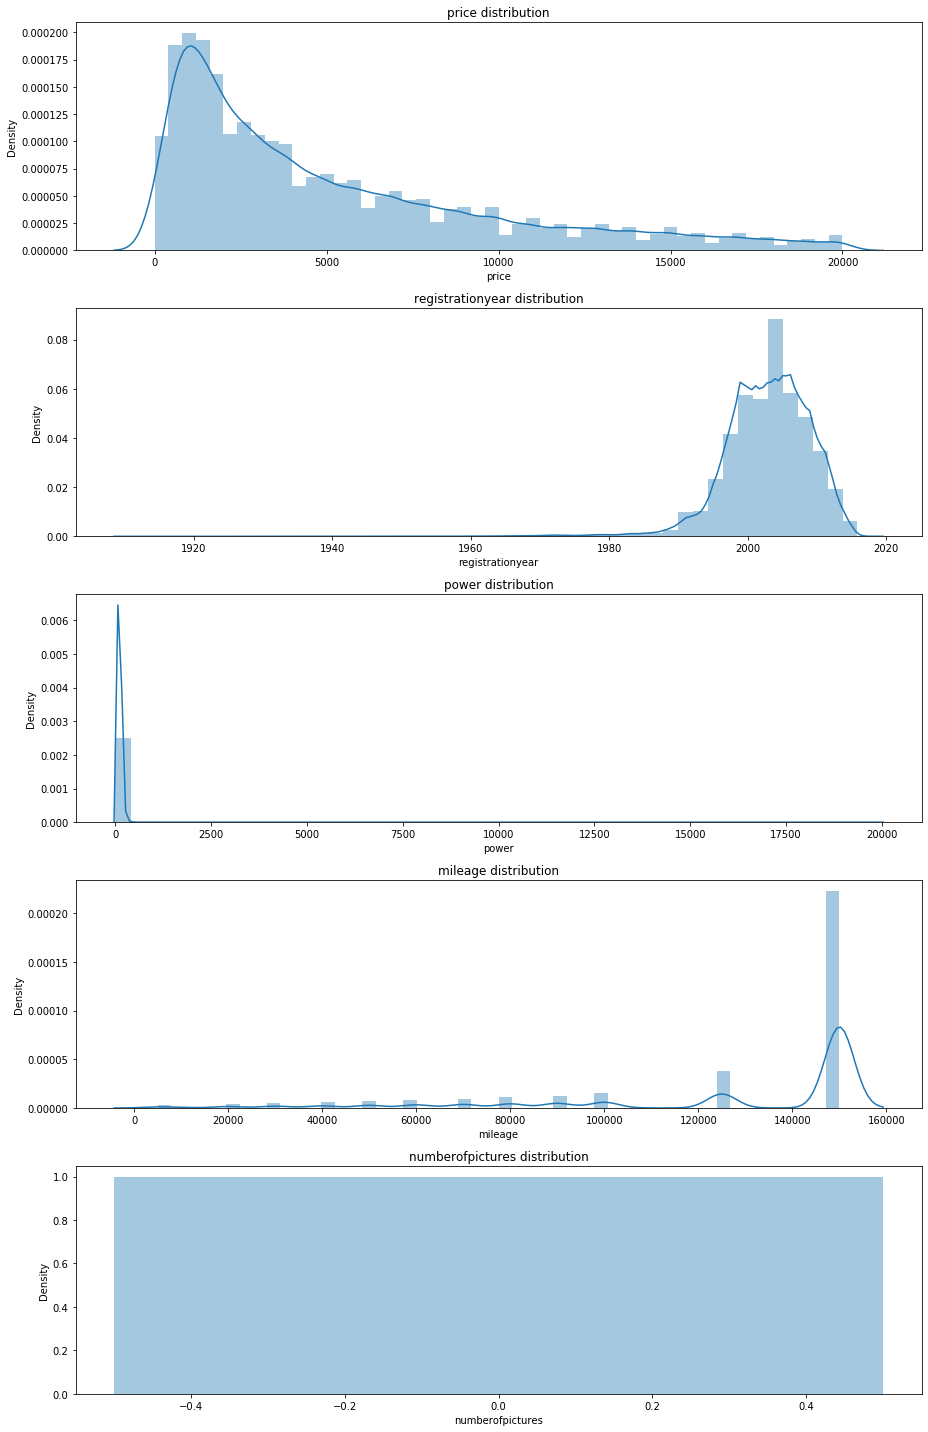

In [37]:
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(13,20))
for index, column in enumerate(numeric_columns):
    sns.distplot(data[column],ax=axes[index], bins = min(50, data[column].max() - data[column].min() + 1))
#     sns.histplot(filled_data[column],ax=axes[index,1], bins = min(50, filled_data[column].max() - filled_data[column].min() + 1))
    axes[index].set_title(f'{column} distribution')
#     axes[index,1].set_title(f'{column} distribution with filled data set')
plt.tight_layout()   

__We have couple of problems here__
- outliers in engine power
- outliers registration year
- number of pictures features is practically useless

In [38]:
numeric_columns.remove('numberofpictures')

In [39]:
# np.percentile(df.power, 99)
# np.percentile(df.registrationyear, 1)

data = data[
    (data.power < np.percentile(data.power, 99)) &
    (data.registrationyear > np.percentile(data.registrationyear, 1))]
filled_data = filled_data[
    (filled_data.power < np.percentile(filled_data.power, 99)) &
    (filled_data.registrationyear > np.percentile(filled_data.registrationyear, 1))]


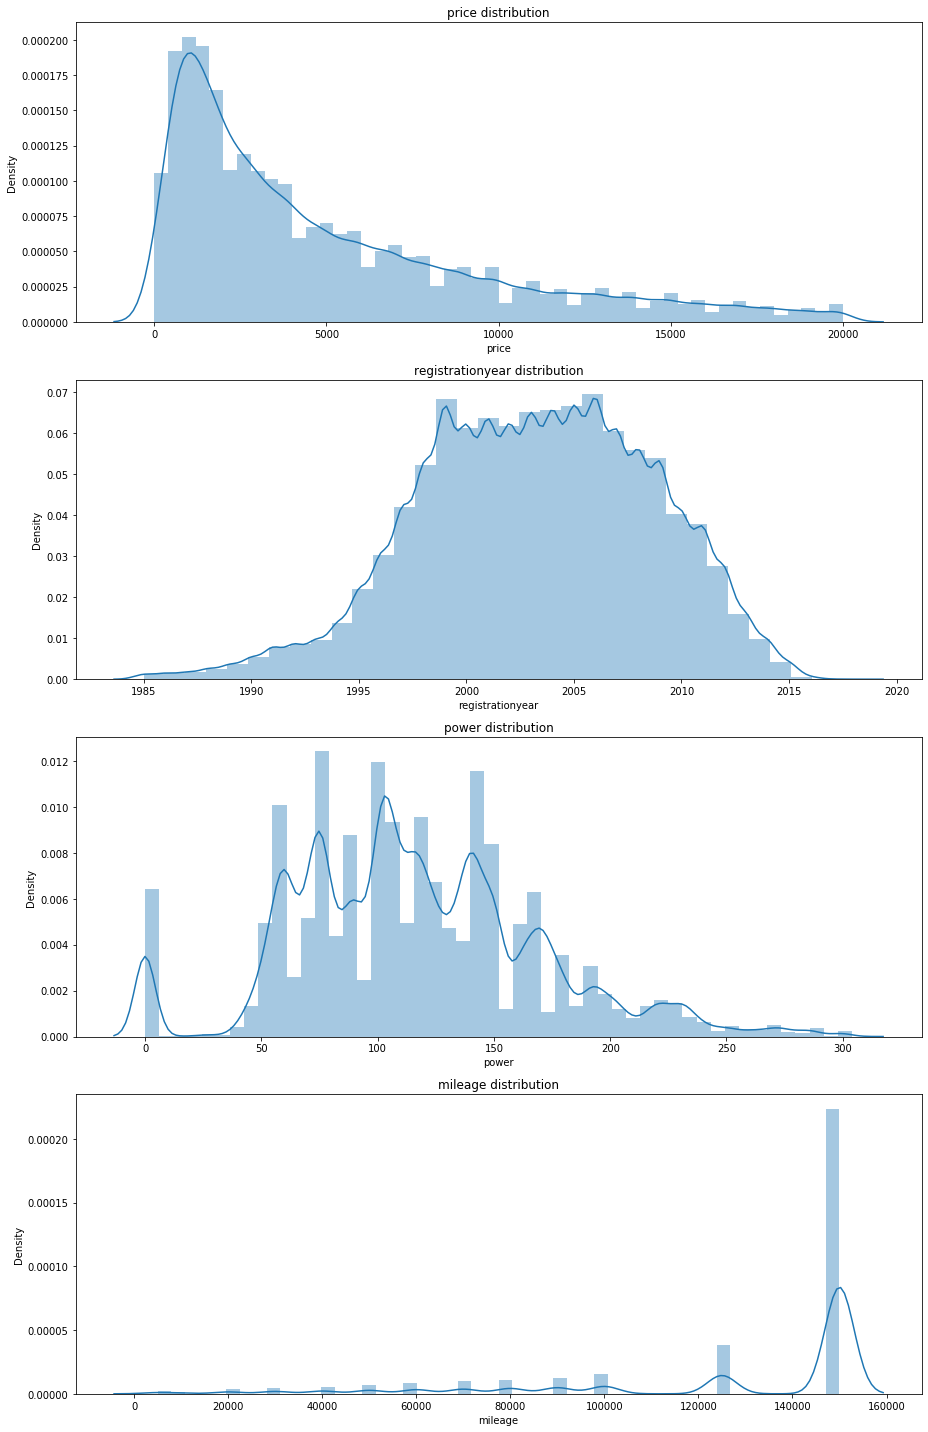

In [40]:
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(13,20))
for index, column in enumerate(numeric_columns):
    sns.distplot(data[column],ax=axes[index], bins = min(50, data[column].max() - data[column].min() + 1))
#     sns.histplot(filled_data[column],ax=axes[index,1], bins = min(50, filled_data[column].max() - filled_data[column].min() + 1))
    axes[index].set_title(f'{column} distribution')
#     axes[index,1].set_title(f'{column} distribution with filled data set')
plt.tight_layout()   

This looks much better, however, vehicles with 0 power are useless, lets ommit them :)

In [41]:
data = data[data.power > np.percentile(data.power, 1)]
filled_data = filled_data[filled_data.power > np.percentile(filled_data.power, 1)]

In [42]:
print(f"{'':<30}|{'percentage of initial data set':^40}|")
print(f"{'Filtered data set':<30}|{data.shape[0]/df.shape[0]:^40.2%}|")
# print(f"{'Data set with restored values':<30}|{filled_data.shape[0]/df.shape[0]:^40.2%}|")

                              |     percentage of initial data set     |
Filtered data set             |                 65.23%                 |


We've lost big chunk of data. Let's train some models and see, whether it was worth trying to restore the data

In [43]:
data.reset_index(inplace=True, drop=True)
filled_data.reset_index(inplace=True, drop=True)

In [44]:
target_col = ['price']
cat_features = categorical_columns
num_features = numeric_columns
num_features.remove('price')

Drop columns that are not in features or target

In [45]:
data.drop([x for x in data.columns if x not in num_features + cat_features + target_col], axis=1, inplace=True)

## Model training

__Base: Linear Regression__

Encode our categorical features, split into train and test sets and scale numerical features

In [46]:
results = dict()

In [47]:
def encode_scale_set(data):
    """Takes data set, encodes categorical values with OrdinalEncoder,
    splits data into train and test sets,
    scales numerical features with Standart Scaler
    and returns resulting data slices"""
    
    target = data[target_col]
    features = data[cat_features+num_features]
    encoder = OrdinalEncoder()
    features[cat_features] = encoder.fit_transform(features[cat_features])

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    scaler.fit(X_train[num_features])
    X_train[num_features] = scaler.transform(X_train[num_features])
    X_test[num_features] = scaler.transform(X_test[num_features])
    return X_train, X_test, y_train, y_test

In [48]:
results['Linear Regression'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

In [49]:
X_train, X_test, y_train, y_test = encode_scale_set(data)

start_train = timeit.default_timer()
lr = LinearRegression()
lr.fit(X_train, y_train)
end_train = timeit.default_timer()

start_prediction = timeit.default_timer()
predictions = lr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['Linear Regression']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['Linear Regression']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['Linear Regression']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

RMSE: 2659.97
Train time: 0.05 sec
Prediction time: 0.00 sec


In [50]:
# X_train, X_test, y_train, y_test = encode_scale_set(filled_data)

# start_train = timeit.default_timer()
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# end_train = timeit.default_timer()

# start_prediction = timeit.default_timer()
# predictions = lr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = math.sqrt(mean_squared_error(y_test, predictions))

# print(f"RMSE: {rmse:.2f}")
# results['Linear Regression']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['Linear Regression']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['Linear Regression']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

This will be our dummie model

__Decision Tree__

In [51]:
results['Decision Tree'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

In [52]:
def ohe_scale_set(data):
    """Takes data set, encodes categorical values with OHE,
    splits data into train and test sets,
    scales numerical features with Standart Scaler
    and returns resulting data slices"""

    target = data[target_col]
    ohe_features = pd.get_dummies(data[cat_features], drop_first=True)
    features = pd.concat([data[num_features], ohe_features], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
    
    scaler = StandardScaler()
    scaler.fit(X_train[num_features])
    X_train[num_features] = scaler.transform(X_train[num_features])
    X_test[num_features] = scaler.transform(X_test[num_features])
    return X_train, X_test, y_train, y_test

In [53]:
X_train, X_test, y_train, y_test = ohe_scale_set(data.sample(10000, random_state=RANDOM_STATE))

parameters = {'max_depth': range(3, 20, 3), 'min_samples_split' : range(2, 20, 2)}
model = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring = 'neg_mean_squared_error')

start_train = timeit.default_timer()
model.fit(X_train, y_train)
end_train = timeit.default_timer()

print(model.best_params_, abs(model.best_score_))

X_train, X_test, y_train, y_test = ohe_scale_set(data)

# dtr = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'])
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
dtr.fit(X_train, y_train)
start_prediction = timeit.default_timer()
predictions = dtr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['Decision Tree']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['Decision Tree']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['Decision Tree']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

{'max_depth': 12, 'min_samples_split': 18} 5101050.612855374
RMSE: 1799.10
Train time: 48.97 sec
Prediction time: 1.14 sec


In [54]:
# %%time

# X_train, X_test, y_train, y_test = ohe_scale_set(filled_data)

# parameters = {'max_depth': range(3, 20, 3), 'min_samples_split' : range(1, 20, 2)}
# dtr = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring = 'neg_root_mean_squared_error')

# start_train = timeit.default_timer()
# dtr.fit(X_train, y_train)
# end_train = timeit.default_timer()

# print(dtr.best_params_, abs(dtr.best_score_))

# start_prediction = timeit.default_timer()
# predictions = dtr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = mean_squared_error(y_test, predictions, squared=False)

# print(f"RMSE: {rmse:.2f}")
# results['Decision Tree']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['Decision Tree']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['Decision Tree']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

__Random Forest__

In [55]:
results['Random Forest'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

In [56]:
X_train, X_test, y_train, y_test = ohe_scale_set(data.sample(10000, random_state=RANDOM_STATE))

parameters = {'n_estimators' : range(20,30,5),'max_depth' : range(15, 21, 1)}

model = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring = 'neg_mean_squared_error')

start_train = timeit.default_timer()
model.fit(X_train, y_train)
end_train = timeit.default_timer()

print(model.best_params_, abs(model.best_score_))

X_train, X_test, y_train, y_test = ohe_scale_set(data)

rfr = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=model.best_params_['max_depth'], n_estimators=model.best_params_['n_estimators'])
rfr.fit(X_train, y_train)

start_prediction = timeit.default_timer()
predictions = rfr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['Random Forest']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['Random Forest']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['Random Forest']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

{'max_depth': 18, 'n_estimators': 25} 3780656.990731113
RMSE: 1600.13
Train time: 88.72 sec
Prediction time: 1.57 sec


In [57]:
# %%time

# X_train, X_test, y_train, y_test = ohe_scale_set(filled_data)

# parameters = {'n_estimators' : range(10,21,5),'max_depth' : range(10, 21, 1)}

# rfr = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), parameters, cv=4, scoring = 'neg_root_mean_squared_error')

# start_train = timeit.default_timer()
# rfr.fit(X_train, y_train)
# end_train = timeit.default_timer()

# print(rfr.best_params_, abs(rfr.best_score_))

# start_prediction = timeit.default_timer()
# predictions = rfr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = mean_squared_error(y_test, predictions, squared=False)

# print(f"RMSE: {rmse:.2f}")
# results['Random Forest']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['Random Forest']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['Random Forest']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

__Cat Boost__

In [58]:
results['CatBoostRegressor'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

This one took around 10 min

In [59]:
X_train, X_test, y_train, y_test = encode_scale_set(data.sample(10000, random_state=RANDOM_STATE))

# catr = CatBoostRegressor(n_estimators=1000, learning_rate=0.15,loss_function="RMSE", random_state=RANDOM_STATE)

parameters = {'learning_rate' : np.arange(0.05, 0.2, 0.05)}
model = GridSearchCV(CatBoostRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring = 'neg_mean_squared_error')

start_train = timeit.default_timer()
model.fit(X_train, y_train, verbose=0)
end_train = timeit.default_timer()

X_train, X_test, y_train, y_test = encode_scale_set(data)

catr = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate = model.best_params_['learning_rate'])
catr.fit(X_train, y_train, verbose=0)
start_prediction = timeit.default_timer()
predictions = catr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['CatBoostRegressor']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['CatBoostRegressor']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['CatBoostRegressor']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

RMSE: 1604.70
Train time: 506.76 sec
Prediction time: 0.05 sec


In [60]:
# %%time
# X_train, X_test, y_train, y_test = encode_scale_set(filled_data)

# catr = CatBoostRegressor(loss_function="RMSE", random_state=RANDOM_STATE)

# start_train = timeit.default_timer()
# catr.fit(X_train, y_train, verbose=100)
# end_train = timeit.default_timer()

# start_prediction = timeit.default_timer()
# predictions = catr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = mean_squared_error(y_test, predictions, squared=False)

# print(f"RMSE: {rmse:.2f}")
# results['CatBoostRegressor']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['CatBoostRegressor']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['CatBoostRegressor']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

__LightGBM__

In [61]:
results['LGBMRegressor'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

In [62]:
X_train, X_test, y_train, y_test = encode_scale_set(data.sample(10000, random_state=RANDOM_STATE))

parameters = {'n_estimators': range(100, 300, 100), 'learning_rate':np.arange(0.05,0.31,0.05)}
model = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE), parameters, cv=3, scoring = 'neg_mean_squared_error')
# lgbr = LGBMRegressor(n_estimators=500, learning_rate = 0.3, random_state=RANDOM_STATE)

start_train = timeit.default_timer()
model.fit(X_train, y_train, feature_name=cat_features+num_features, categorical_feature=cat_features, eval_metric='rmse')
end_train = timeit.default_timer()

print(math.sqrt(abs(model.best_score_)), model.best_params_)

X_train, X_test, y_train, y_test = encode_scale_set(data)

lgbr = LGBMRegressor(n_estimators=model.best_params_['n_estimators'], learning_rate = model.best_params_['learning_rate'], random_state=RANDOM_STATE)
lgbr.fit(X_train, y_train)
start_prediction = timeit.default_timer()
predictions = lgbr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['LGBMRegressor']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['LGBMRegressor']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['LGBMRegressor']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

1812.736096111342 {'learning_rate': 0.05, 'n_estimators': 200}
RMSE: 1656.23
Train time: 94.84 sec
Prediction time: 1.50 sec


In [63]:
# %%time

# X_train, X_test, y_train, y_test = encode_scale_set(filled_data)

# parameters = {'n_estimators': range(100, 1000, 100), 'learning_rate':np.arange(0.05,1,0.05)}
# lgbr = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring = 'neg_root_mean_squared_error')

# start_train = timeit.default_timer()
# lgbr.fit(X_train, y_train, feature_name=cat_features+num_features, categorical_feature=cat_features, eval_metric='rmse')
# end_train = timeit.default_timer()

# print(abs(lgbr.best_score_), lgbr.best_params_)

# start_prediction = timeit.default_timer()
# predictions = lgbr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = mean_squared_error(y_test, predictions, squared=False)

# print(f"RMSE: {rmse:.2f}")
# results['LGBMRegressor']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['LGBMRegressor']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['LGBMRegressor']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

__XGBoost__

In [64]:
results['XGBRegressor'] = dict([('Filtered Data',dict()), ('Filled Data', dict())])

In [65]:
%%time

X_train, X_test, y_train, y_test = ohe_scale_set(data)

xgbr = XGBRegressor(eval_metric='rmse')

start_train = timeit.default_timer()
xgbr.fit(X_train, y_train)
end_train = timeit.default_timer()

start_prediction = timeit.default_timer()
predictions = xgbr.predict(X_test)
end_prediction = timeit.default_timer()

rmse = math.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse:.2f}")
results['XGBRegressor']['Filtered Data']['RMSE'] = f"{rmse:.2f}"
print(f"Train time: {end_train - start_train:.2f} sec")
results['XGBRegressor']['Filtered Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
results['XGBRegressor']['Filtered Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

[08:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1843.39
Train time: 159.34 sec
Prediction time: 1.76 sec
CPU times: user 2min 38s, sys: 1.68 s, total: 2min 39s
Wall time: 2min 42s


In [66]:
# %%time

# X_train, X_test, y_train, y_test = ohe_scale_set(filled_data)

# xgbr = XGBRegressor(eval_metric='rmse')

# start_train = timeit.default_timer()
# xgbr.fit(X_train, y_train)
# end_train = timeit.default_timer()

# start_prediction = timeit.default_timer()
# predictions = xgbr.predict(X_test)
# end_prediction = timeit.default_timer()

# rmse = mean_squared_error(y_test, predictions, squared=False)

# print(f"RMSE: {rmse:.2f}")
# results['XGBRegressor']['Filled Data']['RMSE'] = f"{rmse:.2f}"
# print(f"Train time: {end_train - start_train:.2f} sec")
# results['XGBRegressor']['Filled Data']['Train Time'] = f"{end_train - start_train:.2f} sec"
# print(f"Prediction time: {end_prediction - start_prediction:.2f} sec")
# results['XGBRegressor']['Filled Data']['Prediction Time'] = f"{end_prediction - start_prediction:.2f} sec"

## Model analysis

In [67]:
# print(f"{'':^18}|{'Filtered Data':^42}|{'Filled Data':^42}")
# print()
# print(f"{'Model':^18}|{'RMSE score':^10}|{'train time':^15}|{'pred time':^15}|{'RMSE score':^10}|{'train time':^15}|{'pred time':^15}")
# print(f"{'':-^106}")
# for dictionary in results:
#     print(f"{dictionary:^18}|{results[dictionary]['Filtered Data']['RMSE']:^10}|{results[dictionary]['Filtered Data']['Train Time']:^15}|{results[dictionary]['Filtered Data']['Prediction Time']:^15}|{results[dictionary]['Filled Data']['RMSE']:^10}|{results[dictionary]['Filled Data']['Train Time']:^15}|{results[dictionary]['Filled Data']['Prediction Time']:^15}""")
#     print(f"{'':-^106}")

In [68]:
print(f"{'':^18}|{'Filtered Data':^42}")
print()
print(f"{'Model':^18}|{'RMSE score':^10}|{'train time':^15}|{'pred time':^15}")
print(f"{'':-^60}")
for dictionary in results:
    print(f"{dictionary:^18}|{results[dictionary]['Filtered Data']['RMSE']:^10}|{results[dictionary]['Filtered Data']['Train Time']:^15}|{results[dictionary]['Filtered Data']['Prediction Time']:^15}""")
    print(f"{'':-^60}")

                  |              Filtered Data               

      Model       |RMSE score|  train time   |   pred time   
------------------------------------------------------------
Linear Regression | 2659.97  |   0.05 sec    |   0.00 sec    
------------------------------------------------------------
  Decision Tree   | 1799.10  |   48.97 sec   |   1.14 sec    
------------------------------------------------------------
  Random Forest   | 1600.13  |   88.72 sec   |   1.57 sec    
------------------------------------------------------------
CatBoostRegressor | 1604.70  |  506.76 sec   |   0.05 sec    
------------------------------------------------------------
  LGBMRegressor   | 1656.23  |   94.84 sec   |   1.50 sec    
------------------------------------------------------------
   XGBRegressor   | 1843.39  |  159.34 sec   |   1.76 sec    
------------------------------------------------------------


### Final evaluation
- Linear regression: Our dummy. Fast to train, fast to predict, most inaccurate
- XGBRegressor: We didn't make any hyperparameter tuning, relying on standart algorithms' magic. As a result, pretty bad RMSE and fast train time.Prediction time is relatively slow, compared to LR and CatBoost models
- Decision Tree: Takes pretty long time to perform even basic hyperparameter adjustments. Achieves better results than Linear regression model, yet nothing spectaqular. Takes pretty long to make predictions
- Random Forest: This model training took a very long time. And achieved results definitely were not worth the wait. RMSE score is not the best, and prediction time is the slowest among our trained models
- CatBoostRegressor: We used didn't modify any hyperparameters, and got impressive results. Training process was quick, prediction time is shortest among the models, and with a bit of huperpameters tuning we could possibly achieve even better scores. In exchange for time that be. 
- LGBMRegressor: With this model we've spent a bit of time tuning hyperparameters. Similar to what we've spent on Decision Tree model. Final score is impressive, but prediction time is on the slow side

## Conclusions
- We've downloaded the data, and investigated potential problems
- Changed date fields type to datetime for easier distinction(and space savings?)
- We've made two versions of our data set:
    - In one of them we've tried to restore part of missing values using KNN algorithm. Dropping entries with missing values afterwards
    - With the second one we've dropped all records with missing values right away.
- We've ommited duplicated records and analyzed data destribution, filtering out some outliers in the process.
- Finaly we've decided on fields that we will not use as a feature in training process:
    - Number of pictures, having 0 in every single record would be of no use
    - Postal code probably acts as part of recors id, and should not have effect on price (having distinction based on state, or country region could have an affect, but that's another story)
    - DateTime fields act as an identifyer as well
    - Registration month. Feels like, I don't know, seasonal thing, that would be usefull for analysis of fluctuations in sales throughout the year, but should not affect vehicles price evaluation
- With all that, we've trained and tuned couple of different models, prepairing(encoding and scaling) data for each of them.
- Analyzing final results, if prediction time is the priority, CatBoostRegressor have the lead. With a little bit of time spent on tuning it be a sweet spot between spending hours, and probably days on tuning random forest model, and using booster model with standart hyperparameters
- Restoring missing values prooved to have minimum, if not zero positive impact on our models performance. Considering how long it took to restore them, this step was questionable at the very least